In [1]:
import geokit as gk
import pandas as pd
import numpy as np
import pvlib
# from scipy.interpolate import RectBivariateSpline

import reskit as rk
# from reskit import solarpower
from reskit.workflows.solar import SolarWorkflowGenerator

In [3]:
# placements['capacity'] = 2500
# placements['tilt'] = placements['lat']*0.76
# placements['azimuth'] = 180
# placements['elev'] = 300

# placements.to_csv('c:\\users\\s.ryberg\\fzj\\repos\\res\\reskit\\test\\data\\module_placements.csv', index=False)

In [4]:
placements = pd.read_csv(rk.TEST_DATA['module_placements.csv'])
merra_path=rk.TEST_DATA['merra-like']

In [5]:
wf = SolarWorkflowGenerator(placements)

# tests
assert isinstance( wf.locs, gk.LocationSet)
assert wf.locs.count == placements.shape[0]

In [6]:
wf.read(
    variables=['surface_wind_speed', "surface_pressure", "surface_air_temperature", "surface_dew_temperature", "global_horizontal_irradiance"],
    source_type="MERRA",
    path=merra_path,
    set_time_index=True,
    verbose=False
)

# tests
assert "surface_wind_speed" in wf.sim_data
assert "surface_pressure" in wf.sim_data
assert "surface_air_temperature" in wf.sim_data
assert "global_horizontal_irradiance" in wf.sim_data

assert wf.sim_data['global_horizontal_irradiance'].shape[0] == len(wf.time_index)
assert wf.sim_data['global_horizontal_irradiance'].shape[1] == wf.locs.count

assert wf.surface_wind_speed_height == 2
# print(wf.sim_data['global_horizontal_irradiance'].mean(), wf.sim_data['global_horizontal_irradiance'].std())
assert np.isclose( wf.sim_data['global_horizontal_irradiance'].mean(), 29.051229857488853 )
assert np.isclose( wf.sim_data['global_horizontal_irradiance'].std(), 57.41876854447587)

In [7]:
wf.determine_solar_position()

# tests 
assert "solar_azimuth" in wf.sim_data
assert "apparent_solar_zenith" in wf.sim_data
assert "apparent_solar_elevation" in wf.sim_data

# print(wf.sim_data['solar_zenith'].mean(), wf.sim_data['solar_zenith'].std())
assert np.isclose( wf.sim_data['apparent_solar_zenith'].mean(), 109.2598193185083 )
assert np.isclose( wf.sim_data['apparent_solar_zenith'].std(), 26.62641165426258)


In [8]:
wf.filter_positive_solar_elevation()

# tests 
assert wf._time_sel_.sum() == 27
assert wf._sim_shape_ == (27,560)
assert wf.sim_data['global_horizontal_irradiance'].shape == wf._sim_shape_

In [9]:
wf.determine_extra_terrestrial_irradiance(model="spencer", solar_constant=1370)

# print(wf.sim_data['extra_terrestrial_irradiance'].mean(), wf.sim_data['extra_terrestrial_irradiance'].std())
assert np.isclose( wf.sim_data['extra_terrestrial_irradiance'].mean(), 1418.0397631172639   )
assert np.isclose( wf.sim_data['extra_terrestrial_irradiance'].std(), 0.015717104724686137)

In [10]:
wf.determine_air_mass(model='kastenyoung1989')
    
# print(wf.sim_data['air_mass'].mean(), wf.sim_data['air_mass'].std())
assert np.isclose( wf.sim_data['air_mass'].mean(), 10.355618714207562 )
assert np.isclose( wf.sim_data['air_mass'].std(), 9.517938562733685)

In [11]:
wf.apply_DIRINT_model()

# print(wf.sim_data['direct_normal_irradiance'].mean(), wf.sim_data['direct_normal_irradiance'].std())
assert np.isclose( wf.sim_data['direct_normal_irradiance'].mean(), 115.40545782258317   )
assert np.isclose( wf.sim_data['direct_normal_irradiance'].std(), 191.2154118864899)

In [12]:
wf.diffuse_horizontal_irradiance_from_trigonometry()

# print(wf.sim_data['diffuse_horizontal_irradiance'].mean(), wf.sim_data['diffuse_horizontal_irradiance'].std())
assert np.isclose( wf.sim_data['diffuse_horizontal_irradiance'].mean(), 50.056181976873205    )
assert np.isclose( wf.sim_data['diffuse_horizontal_irradiance'].std(), 39.35888797182079)

In [13]:
wf.permit_single_axis_tracking(max_angle=90, backtrack=True, gcr=2.0/7.0)

# print(wf.sim_data['system_tilt'].mean(), wf.sim_data['system_tilt'].std())
assert np.isclose( wf.sim_data['system_tilt'].mean(), 49.672198525949106  )
assert np.isclose( wf.sim_data['system_tilt'].std(), 10.248233044342607)

In [14]:
wf.determine_angle_of_incidence()

# print(wf.sim_data['angle_of_incidence'].mean(), wf.sim_data['angle_of_incidence'].std())
assert np.isclose( wf.sim_data['angle_of_incidence'].mean(), 38.981053931482315 )
assert np.isclose( wf.sim_data['angle_of_incidence'].std(), 17.920415717356125)

In [15]:
wf.estimate_plane_of_array_irradiances(transposition_model="perez")

# print(wf.sim_data['poa_global'].mean(), wf.sim_data['poa_global'].std())
assert np.isclose( wf.sim_data['poa_global'].mean(), 166.80629716820266   )
assert np.isclose( wf.sim_data['poa_global'].std(), 197.5504286463543)

In [16]:
wf.cell_temperature_from_sapm(mounting="glass_open_rack")

# print(wf.sim_data['cell_temperature'].mean(), wf.sim_data['cell_temperature'].std())
assert np.isclose( wf.sim_data['cell_temperature'].mean(), 6.42996975079079    )
assert np.isclose( wf.sim_data['cell_temperature'].std(), 6.0195612441499735)

In [17]:
wf.apply_angle_of_incidence_losses_to_poa()

# print(wf.sim_data['poa_global'].mean(), wf.sim_data['poa_global'].std())
assert np.isclose( wf.sim_data['poa_global'].mean(), 163.46836520664434       )
assert np.isclose( wf.sim_data['poa_global'].std(), 195.06998924136013)

In [22]:
wf.simulate_with_interpolated_single_diode_approximation()

# print(wf.sim_data['capacity_factor'].mean(), wf.sim_data['capacity_factor'].std())
assert np.isclose( wf.sim_data['capacity_factor'].mean(), 0.220608950019893   )
assert np.isclose( wf.sim_data['capacity_factor'].std(), 0.26139821393299295)

# print(wf.sim_data['total_system_generation'].mean(), wf.sim_data['total_system_generation'].std())
assert np.isclose( wf.sim_data['total_system_generation'].mean(), 551.5223750497324       )
assert np.isclose( wf.sim_data['total_system_generation'].std(), 653.4955348324822)

551.5223750497324 653.4955348324822


In [48]:
if 'capacity' in wf.placements.columns:
    del wf.placements['capacity']
    wf.placements['modules_per_string'] = 2
    wf.placements['strings_per_inverter'] = 1
    wf.placements['number_of_inverters'] = 5

wf.apply_inverter_losses(inverter="SolarBridge_Technologies__P250HV_208_240_xxx")

# print(wf.sim_data['capacity_factor'].mean(), wf.sim_data['capacity_factor'].std())
assert np.isclose( wf.sim_data['capacity_factor'].mean(), 0.17700338984555017     )
assert np.isclose( wf.sim_data['capacity_factor'].std(), 0.18714937315703425)

# print(wf.sim_data['total_system_generation'].mean(), wf.sim_data['total_system_generation'].std())
assert np.isclose( wf.sim_data['total_system_generation'].mean(), 425.5019889175149     )
assert np.isclose( wf.sim_data['total_system_generation'].std(), 449.8921211196579)

In [49]:
wf.apply_loss_factor(0.20, variables=['capacity_factor','total_system_generation'])

# print(wf.sim_data['capacity_factor'].mean(), wf.sim_data['capacity_factor'].std())
assert np.isclose( wf.sim_data['capacity_factor'].mean(), 0.14160271187644013   )
assert np.isclose( wf.sim_data['capacity_factor'].std(), 0.14971949852562744)

# print(wf.sim_data['total_system_generation'].mean(), wf.sim_data['total_system_generation'].std())
assert np.isclose( wf.sim_data['total_system_generation'].mean(), 340.401591134012  )
assert np.isclose( wf.sim_data['total_system_generation'].std(), 359.9136968957263)

0.14160271187644013 0.14971949852562744
340.401591134012 359.9136968957263


In [1]:
## TEST THESIS WORKFLOW
import pandas as pd
import reskit as rk
import numpy as np
from reskit.workflows.solar import openfield_pv_with_merra_ryberg2019

xds = openfield_pv_with_merra_ryberg2019(
    placements = pd.read_csv(rk.TEST_DATA['module_placements.csv']),
    merra_path = rk.TEST_DATA['merra-like'],
    global_solar_atlas_ghi_path = rk.TEST_DATA['gsa-ghi-like.tif'],
)


# print(xds['capacity_factor'].fillna(0).mean(), xds['capacity_factor'].fillna(0).std())
assert np.isclose( xds['capacity_factor'].fillna(0).mean(), 0.04232331 )
assert np.isclose( xds['capacity_factor'].fillna(0).std(), 0.09861673)

In [5]:
## TEST ERA5 WORKFLOW
import pandas as pd
import reskit as rk
import numpy as np
from reskit.workflows.solar import openfield_pv_with_era5_unvalidated


xds2 = openfield_pv_with_era5_unvalidated(
    placements = pd.read_csv(rk.TEST_DATA['module_placements.csv']),
    era5_path = rk.TEST_DATA['era5-like'],
    global_solar_atlas_ghi_path = rk.TEST_DATA['gsa-ghi-like.tif'],
    global_solar_atlas_dni_path = rk.TEST_DATA['gsa-dni-like.tif'],
)


# print(xds2['capacity_factor'].fillna(0).mean(), xds2['capacity_factor'].fillna(0).std())
assert np.isclose( xds2['capacity_factor'].fillna(0).mean(), 0.10311327 )
assert np.isclose( xds2['capacity_factor'].fillna(0).std(), 0.19797446)

C:\Users\s.ryberg\AppData\Local\Continuum\anaconda3\envs\sevpy\lib\site-packages\pvlib\irradiance.py:1056: RuntimeWarning: divide by zero encountered in true_divide
  eps = ((dhi + dni) / dhi + kappa * (z ** 3)) / (1 + kappa * (z ** 3))


In [6]:
## TEST SARAH WORKFLOW
import pandas as pd
import reskit as rk
import numpy as np
from reskit.workflows.solar import openfield_pv_with_sarah_unvalidated

xds3 = openfield_pv_with_sarah_unvalidated(
    placements = pd.read_csv(rk.TEST_DATA['module_placements.csv']),
    sarah_path = rk.TEST_DATA['sarah-like'],
    era5_path = rk.TEST_DATA['era5-like']
)


# print(xds3['capacity_factor'].fillna(0).mean(), xds3['capacity_factor'].fillna(0).std())
assert np.isclose( xds3['capacity_factor'].fillna(0).mean(), 0.14937886 )
assert np.isclose( xds3['capacity_factor'].fillna(0).std(), 0.252294)

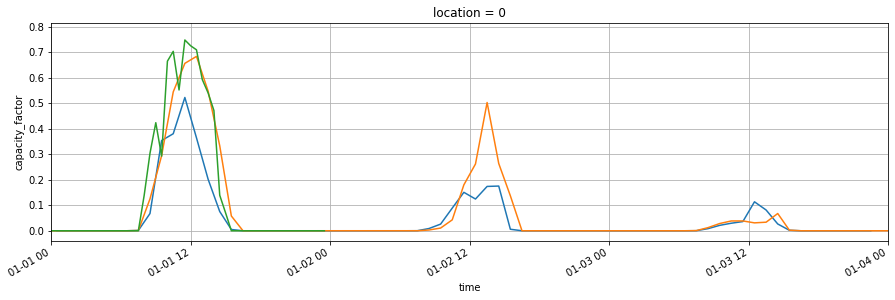

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

var = "capacity_factor"
xds[var][:,0].fillna(0).plot()
xds2[var][:,0].fillna(0).plot()
xds3[var][:,0].fillna(0).plot()

plt.grid()

plt.gca().set_xlim( pd.Timestamp("2015-01-01 00:00:00"), pd.Timestamp("2015-01-04 00:00:00" ) )
plt.show()